# Fluid-Implicit-Particle (FLIP) Simulations

FLIP simulations employ particles to track volume / mass elements but use grids to compute global effects, such as pressure.
The space not filled by these elements, such as the air, is not simulated.

This notebook shows how to run an incompressible liquid simulation in Φ<sub>Flow</sub>.

In [1]:
# !pip install git+https://github.com/tum-pbs/PhiFlow@3.0
from phi.jax.flow import *
from phi.field._point_cloud import distribute_points
from tqdm.notebook import trange

We start by creating the simulation domain including obstacles.
Here, we add a heightmap-based ground to our simulation and explicitly specify the height values here.

Next, we divide the domain into cells which are needed for the pressure computation.
Finally, we scatter the initial fluid particles in a rectangular region in the top right.

<Figure size 864x360 with 2 Axes>

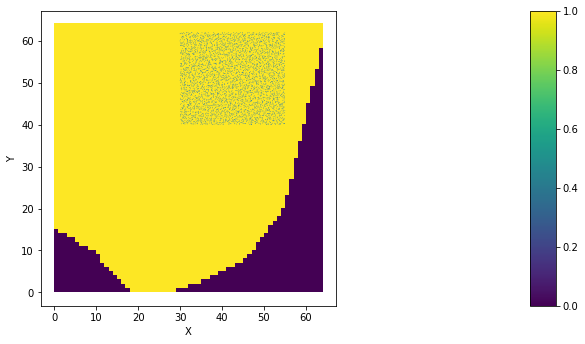

In [2]:
domain = Box(x=64, y=64)
ground = geom.Heightmap(wrap([15, 10, 0, 0, 3, 8, 20, 60], spatial('x')), domain, max_dist=10)
accessible_cells = CenteredGrid(~ground, 0, domain, x=64, y=64)
particles = distribute_points(union(Box(x=(30, 55), y=(40, 62))), x=64, y=64, bounds=domain) * (0, 0)
plot(accessible_cells, particles, overlay='args')

Next we define the step function which evolves the state in time.

In [11]:
@jit_compile
def step(particles: Field, pressure=None, dt=.2, gravity=vec(x=0, y=-9.81)):
    # --- Grid Operations ---
    grid_v = prev_grid_v = field.finite_fill(resample(particles, StaggeredGrid(0, 0, x=64, y=64), scatter=True, outside_handling='clamp'))
    occupied = resample(field.mask(particles), CenteredGrid(0, grid_v.extrapolation.spatial_gradient(), grid_v.bounds, grid_v.resolution), scatter=True, outside_handling='clamp')
    grid_v, pressure = fluid.make_incompressible(grid_v + gravity * dt, [ground], active=occupied)
    # --- Particle Operations ---
    particles += resample(grid_v - prev_grid_v, to=particles)  # FLIP update
    # particles = resample(grid_v, particles)  # PIC update
    particles = advect.points(particles, grid_v * mask(~ground), dt, advect.finite_rk4)
    particles = fluid.boundary_push(particles, [ground, ~domain], separation=.5)
    return particles, pressure

Let's run the simulation for 100 time steps and visualize the final state.

  0%|          | 0/100 [00:00<?, ?it/s]

<Figure size 864x360 with 2 Axes>

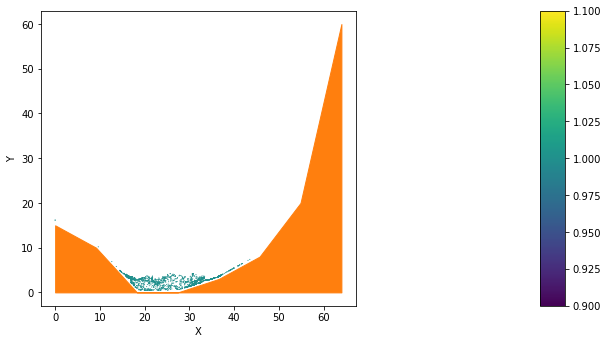

In [15]:
particle_trj, p_trj = iterate(step, batch(t=100), particles, None, range=trange)
plot(field.mask(particle_trj).t[-1], ground, overlay='args')

Using the `animate` argument, we can create a video of the simulation.

In [16]:
plot(particle_trj, ground, overlay='args', animate='t')